# Predicting House Prices Using Advanced Regression Techniques

# Abstract

In this project, we were aiming to build a model that could accurately predict house sale prices using the 'Ames house data set': this contains 79 feature variables for almost 3000 houses that were sold in this area of Iowa between 2006-2010. Following detailed exploration and cleaning of the data, we engineered and transformed the features and used *pycaret* to select the models we would use. In this selection, the *CatBoost Regressor* performed best, so we used this to train a baseline model. Our k-fold validation evaluated this model as achieving a RMSE of 1.1259 (so an error of just over a dollar!): to put this in context, the mean sales price was $180,921, so our model was predicting with a high degree of accuracy. We used this model to make predictions on the test set (as part of a Kaggle competition) and achieved a RMSE of 1.1325. We then optimzed the parameters and used a bagging emsemble to attempt even greated accuracy. This ensemble model returned a RMSE 1.1289 for the test set, which was an improvement on the baseline. We concluded that we had trained an effective model that could be used for house price predictions for similar datasets; and made suggestions for further improvements.



# 1. Introduction

### The Data

In this project, we will be using The Ames house data set that is available [here.](http://jse.amstat.org/v19n3/decock.pdf) It was compiled by Dean De Cock for use in data science training/education. 

The dataset contains 79 variables that describe practically every aspect of residential homes in Ames, Iowa. 

### The Challenge

> Can we build a model that successfully predicts the final selling price of each home in our data set?

### Resources

#### Data Exploration
[This notebook](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) by Pedro Marcelino provides excellent suggestions on how to get really well-acquainted with the data and undertake initial explorations. My data exploration section is based on his framework.

#### Preparing the data, selecting the models and optimizing
My work here is based on the excellent walkthrough by Gabriel Atkin. The video of his walkthrough is [here](https://www.youtube.com/watch?v=zwYHloLXH0c) and the relevant notebook is [here.](https://www.kaggle.com/gcdatkin/top-10-house-price-regression-competition-nb/notebook) 

### Imports

In [2]:
# imports of required libraries:

import numpy as np
import pandas as pd
pd.set_option('max_columns', None) #allows us to see all columns without truncation
pd.set_option('max_rows',90) #allows us to see up to 90 rows without truncation
pd.set_option('display.float_format', lambda x: '%.3f' % x) #limits output to 3 decimal places

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
from pycaret.regression import setup, compare_models
from sklearn.model_selection import KFold, cross_val_score

from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import optuna

## 2. Data Exploration

As a starting point to get to know the data, Pedro Marcelino suggests creating an Excel spreadsheet with the following columns: 

* **Variable**: the variable name
* **Type**: whether the variable is categorical or numerical
* **Segment**: what segment of the data this variable seems to fall into. This will usually require some domain knowledge to create these segements. In the case of this housing data, the segments may be 'building' (ie. physical characteristics), 'space' (space properties of the house) and 'location' (info about where the property is located). 
* **Expectation**: our expectation about the influence this variable will have on the target variable (in this case, the sales price). We can use the categories of 'High', 'Medium' and 'Low' for this. 
* **Conclusion**: what we initially think about the importance of this variable (again, we can use 'High', 'Medium', 'Low').
* **Comments**: any general comments. 

I believe this is an excellent starting point for any data set, as it gets us to really begin thinking about how the different features may be related to one another and the target. I followed these steps to get a good understand of the data before deliving into the exploration/cleaning/engineering. 

Now, let's read in the train and test datasets and have a first look at them here: 

In [3]:
train0=pd.read_csv('train.csv') 
test0=pd.read_csv('test.csv')

In [4]:
print('The shape of the training set is as follows: ' +str(train0.shape))
print('The shape of the test set is as follows: ' +str(test0.shape))

The shape of the training set is as follows: (1460, 81)
The shape of the test set is as follows: (1459, 80)


In [5]:
train0.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
test0.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,CBlock,TA,TA,No,Rec,468.000,LwQ,144.000,270.000,882.000,GasA,TA,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000,Unf,1.000,730.000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,TA,TA,CBlock,TA,TA,No,ALQ,923.000,Unf,0.000,406.000,1329.000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000,Unf,1.000,312.000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,GLQ,791.000,Unf,0.000,137.000,928.000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000,0.000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000,Fin,2.000,482.000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000,TA,TA,PConc,TA,TA,No,GLQ,602.000,Unf,0.000,324.000,926.000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000,0.000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000,Fin,2.000,470.000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000,Unf,0.000,1017.000,1280.000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000,0.000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.000,RFn,2.000,506.000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


We will just check that there are no duplicates in either dataset:

In [7]:
unique_ids=len(set(train0.Id))
total_ids=train0.shape[0]
no_dups=total_ids-unique_ids
print('There are a total of '+str(no_dups)+' duplicate IDs for ' + str(total_ids)+ ' total entries')

There are a total of 0 duplicate IDs for 1460 total entries


In [8]:
# check the test data for duplicates

unique_ids=len(set(test0.Id))
total_ids=test0.shape[0]
no_dups=total_ids-unique_ids
print('There are a total of '+str(no_dups)+' duplicate IDs for ' + str(total_ids)+ ' total entries')

There are a total of 0 duplicate IDs for 1459 total entries


In [9]:
train0.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

The 81 columns in the training dataset are comprised of the following: 
* An `Id` column
* 79 features that describe the properties
* The `SalePrice` column: this is the variable we will be predicting

The test set also has an `Id` column and the 79 features, but does not have the `SalePrice` column.

### Target Variable

Let's have a close look at the value we are trying to predict (our target variable), `SalesPrice`:

In [10]:
#create the variable for just the target column:
target=train0['SalePrice'] 

<Figure size 864x288 with 0 Axes>

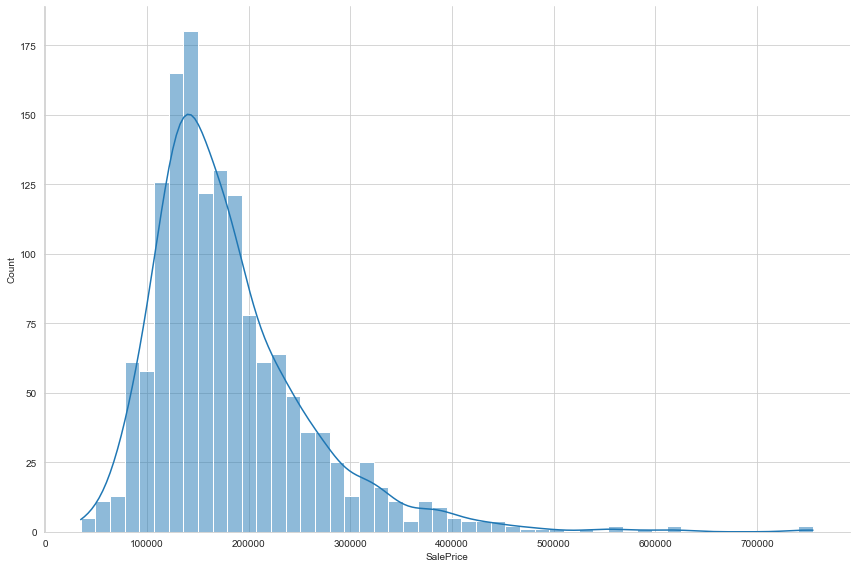

In [11]:
plt.figure(figsize=(12,4))
sns.displot(data=target,height=8,aspect=1.5, bins=50,kde=True)

In [12]:
#skewness and kurtosis
print("Skewness: %f" % target.skew())
print("Kurtosis: %f" % target.kurt())

Skewness: 1.882876
Kurtosis: 6.536282


The above suggests that the `SalePrice` values are very skewed (a value of less than -1 or greater than 1 suggests a high degree of skew). As such, let's explore whether log transforming the data will address this skew:

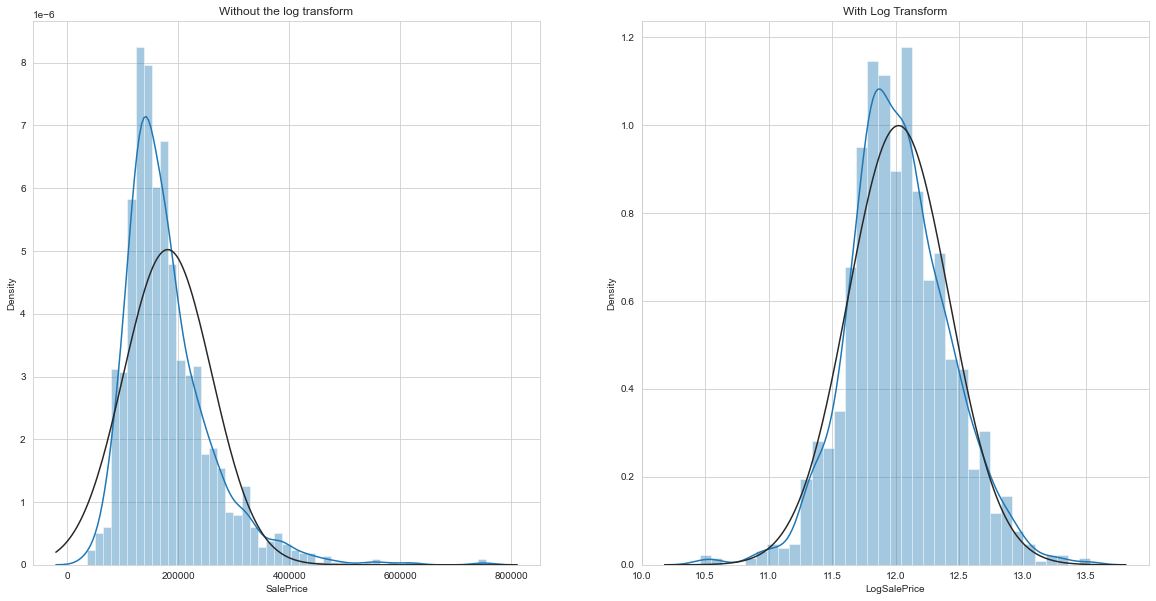

In [13]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.distplot(target, kde=True, fit=scipy.stats.norm)
plt.title('Without the log transform')

plt.subplot(1,2,2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)
plt.xlabel('LogSalePrice')
plt.title('With Log Transform')

plt.show()

The data is much more normally distributed with the log transform, so we will likely decide to make this transformation. For now, let's continue with our initial exploration.

### Initial Exploration: The Target Variable's Relationship with Numerical Variables

We can see in the above histograms that there are some extreme values for `SalePrice`: a few houses that sold for over $500K. In [the article describing this data,](http://jse.amstat.org/v19n3/decock.pdf) the author warns of outliers: 

> *There are five observations that an instructor may wish to remove from the data set before giving
it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these
points).*

Let's create the plot the author suggests to explore further (for this section we will use just the `train` dataset, as this also contains the target variable):

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

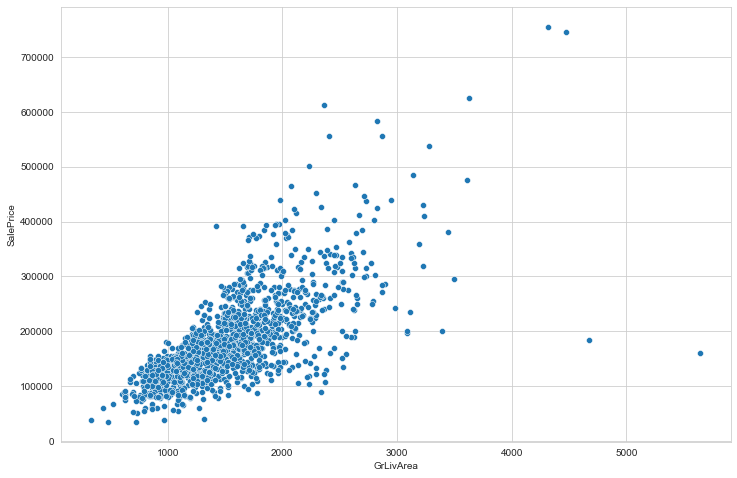

In [14]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=train0,x='GrLivArea',y='SalePrice')

It looks like there is a strong linear relationship between these two variables. However, we can see that there are some properties with a large area (>4000 sq ft) that are outliers. A couple of them also seem to have sold for a surprisingly low price. 

Let's also look at the relationship between `SalePrice` and `TotanBsmtSF`: 

<AxesSubplot:title={'center':'TotalBsmtSF vs SalePrice'}, xlabel='TotalBsmtSF', ylabel='SalePrice'>

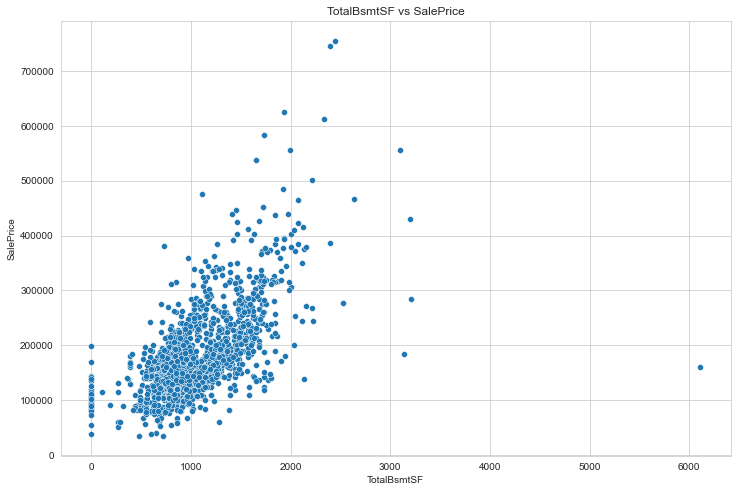

In [15]:
plt.figure(figsize=(12,8))
plt.title('TotalBsmtSF vs SalePrice')
sns.scatterplot(data=train0,x='TotalBsmtSF',y='SalePrice')

There is a relationship here, but not as strong as that between SalePrice and `GrLvArea`.

### Initial Exploration: The Target Variable's Relationship with Categorical Variables

It seems reasonable to think that the category `OverallQual` will have a strong relationshiop with `SalePrice`: surely the quality of the property will play an import part in the sale! Let's explore this relationship:

Text(0.5, 1.0, 'OverallQual vs SalePrice')

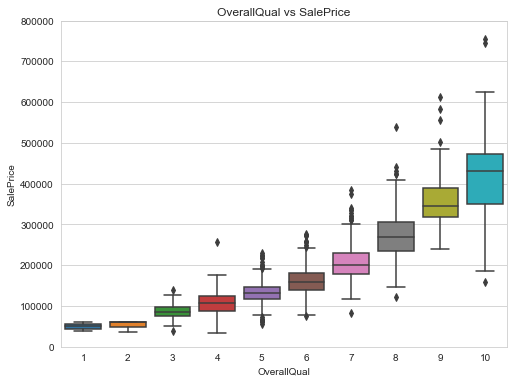

In [16]:
var = 'OverallQual'
data = pd.concat([train0['SalePrice'], train0[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.title('OverallQual vs SalePrice')

From the above we can see that there is a relationship between `SalePrice` and `OverallQual`.

Similary, it seems reasonable to suggest that the year the property was built will play a part in the sale price. Let's have a look at this relationship:

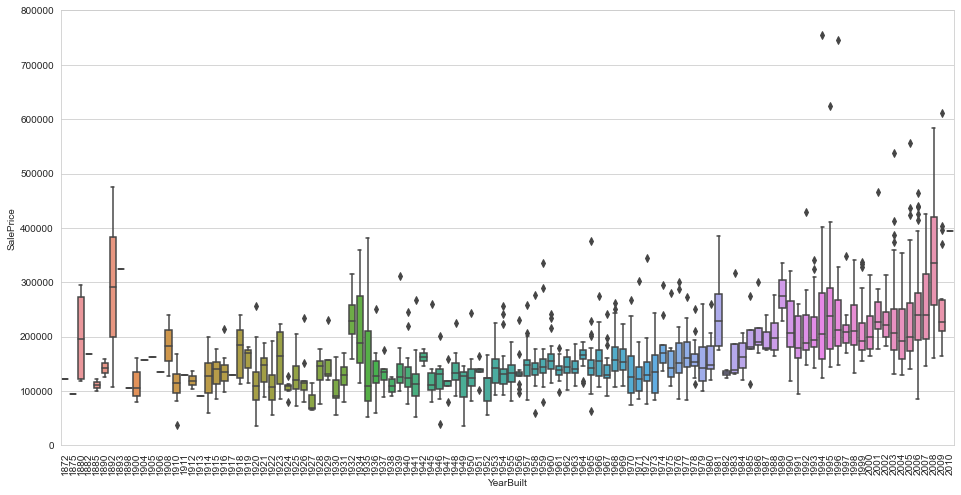

In [17]:
var = 'YearBuilt'
data = pd.concat([train0['SalePrice'], train0[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

There's not a strong tendency here, but there is something of a linear relationship between `YearBuilt` and `SalePrice`. 

### Summary of Initial Explorations

* `GrLivArea` and `TotalBsmtSF` seem to be linearly related with `SalePrice`. Both of the relationships are positive, which means that as one increases, the other increases also. In the case of `TotalBsmtSF`, we can see that the slope of the linear relationship is particularly high
* `OverallQual` and `YearBuilt` also seem to be related with `SalePrice`. The relationship seems stronger in the case of `OverallQual`, where the box plot shows how sale prices increase with the overall quality. 

### Further Exploration of Numerical Features

We will follow these steps: 

* Correlation matrix (heatmap)
* `SalePrice` correlation matrix (zoomed heatmap)
* Scatter plots between the most correlated variables 

<AxesSubplot:>

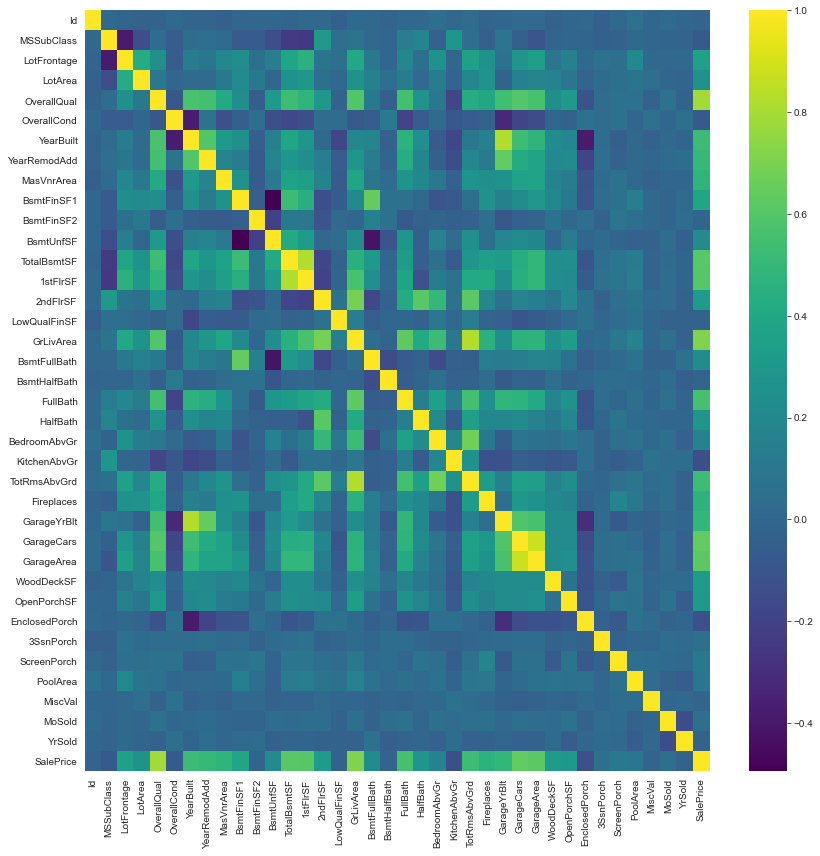

In [18]:
#heatmap first

plt.figure(figsize=(14,14))
sns.heatmap(data=train0.corr(),cmap='viridis')

From the above, we can see a really strong relationship between `TotalBsmtSF` and `1stFlrSF`; and between the garage variables. This could indicate multicollinearity- this makes sense if we consider what the variables are measuring. 

The above also give us an initial indication of what correlates with `SalePrice`, which we will now take a look at in more detail: 

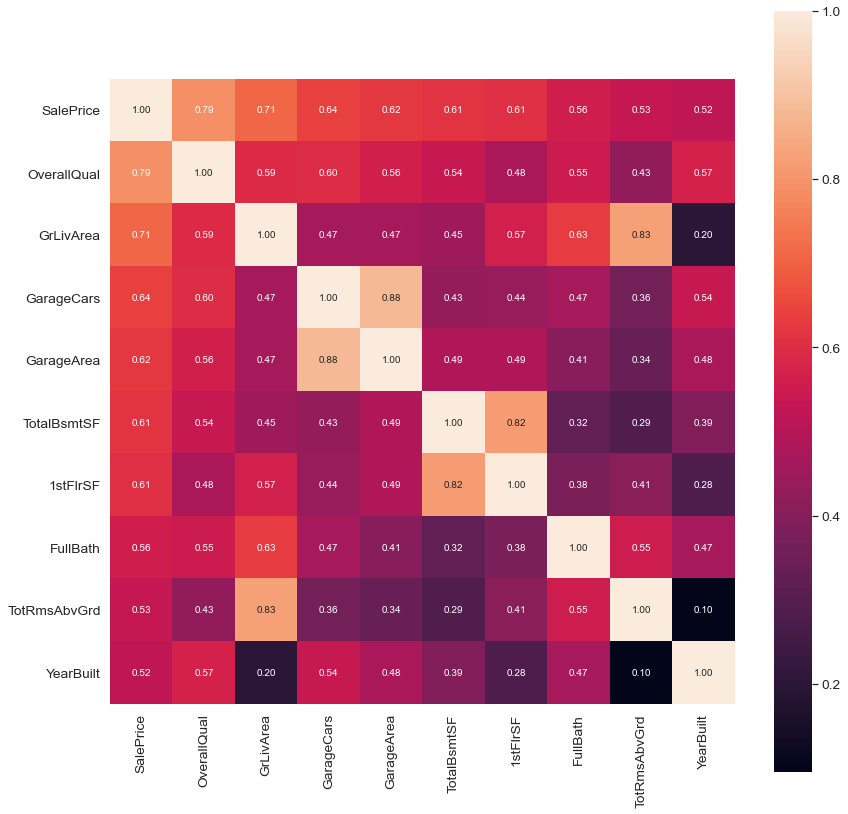

In [19]:
#saleprice correlation matrix
plt.figure(figsize=(14,14))
corrmat = train0.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train0[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [20]:
print("Correlation with the SalePrice column:")
train0.corr()['SalePrice'].sort_values(ascending=False)

Correlation with the SalePrice column:


SalePrice        1.000
OverallQual      0.791
GrLivArea        0.709
GarageCars       0.640
GarageArea       0.623
TotalBsmtSF      0.614
1stFlrSF         0.606
FullBath         0.561
TotRmsAbvGrd     0.534
YearBuilt        0.523
YearRemodAdd     0.507
GarageYrBlt      0.486
MasVnrArea       0.477
Fireplaces       0.467
BsmtFinSF1       0.386
LotFrontage      0.352
WoodDeckSF       0.324
2ndFlrSF         0.319
OpenPorchSF      0.316
HalfBath         0.284
LotArea          0.264
BsmtFullBath     0.227
BsmtUnfSF        0.214
BedroomAbvGr     0.168
ScreenPorch      0.111
PoolArea         0.092
MoSold           0.046
3SsnPorch        0.045
BsmtFinSF2      -0.011
BsmtHalfBath    -0.017
MiscVal         -0.021
Id              -0.022
LowQualFinSF    -0.026
YrSold          -0.029
OverallCond     -0.078
MSSubClass      -0.084
EnclosedPorch   -0.129
KitchenAbvGr    -0.136
Name: SalePrice, dtype: float64

From the above, we can observe the following: 

* `OverallQual`,`GrLivArea` and `TotalBsmtSF` are strongly correlated with `SalePrice`
* `GarageCars` and `GarageArea` are some of the most strongly correlated variables. As they are so inter-related (ie. the number of cars in a garage is related to its' size), we really only need one of them for our analysis. 
* `TotalBsmtSF` and `1stFloor` also seem to be inter-related: we only need one of them 
* `TotRmsAbvGrd` and `GrLivArea` also seem to be twins...
* `YearBuilt` seems to be mildly correlated with `SalePrice`

Let's do some scatter plots of these to visualise the above:

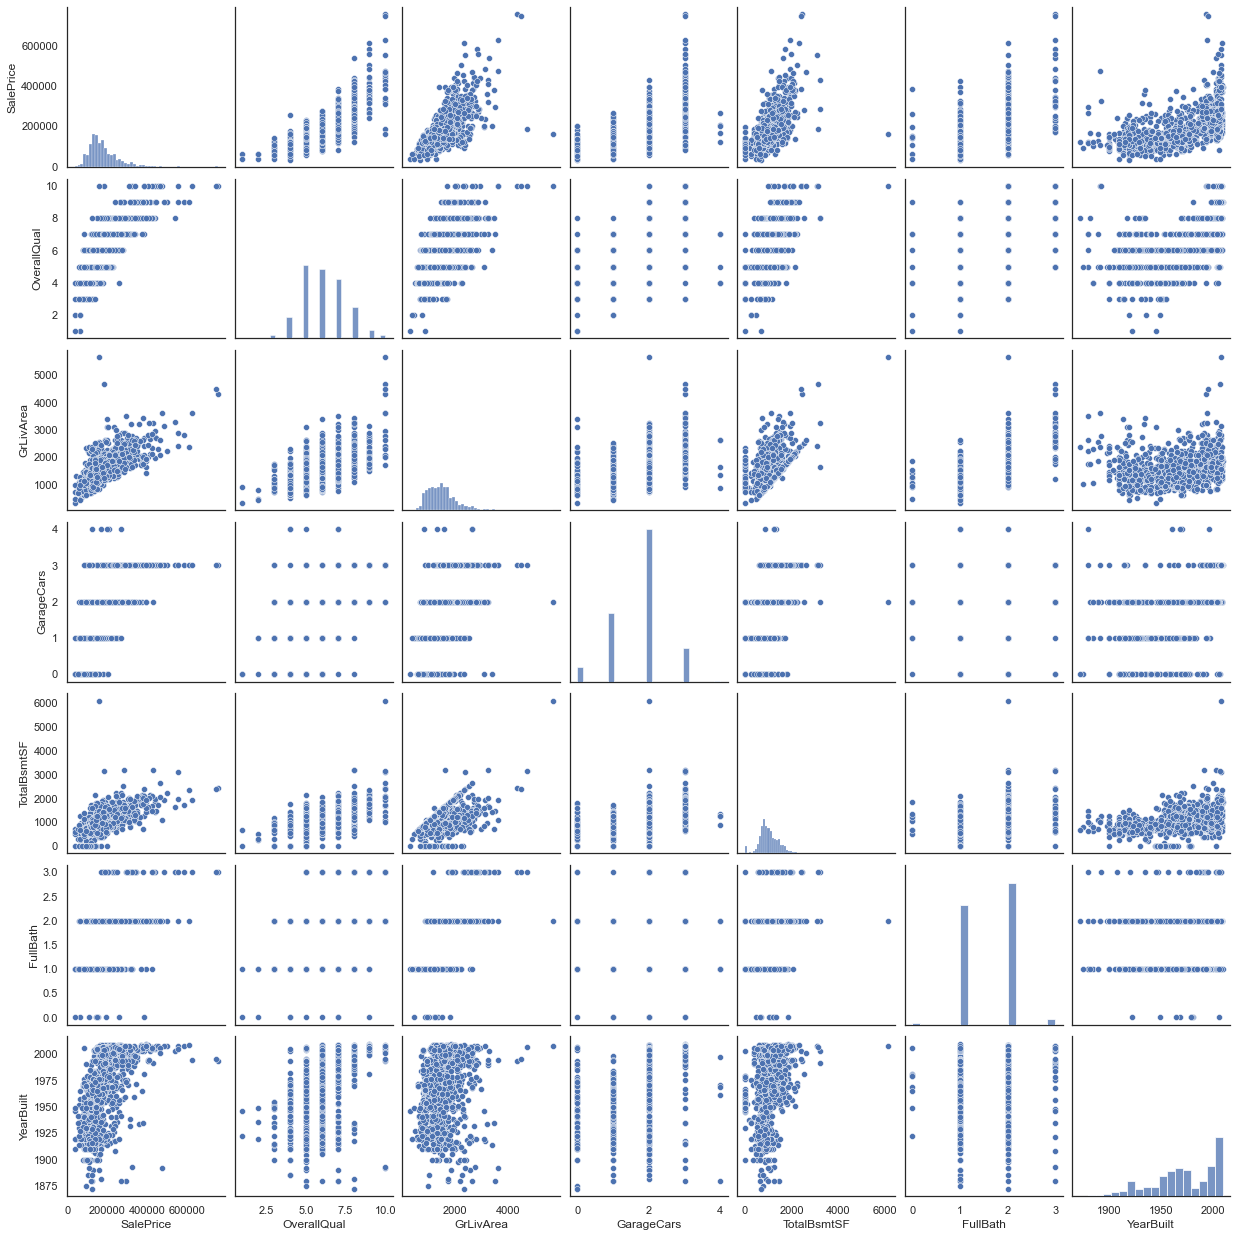

In [21]:
#scatterplot
sns.set()
sns.set_style('white')
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train0[cols], height = 2.5)
plt.show();

## 3. Data Cleaning

### Combine the Train and Test Sets

Before we go any further, we are going to combine the train and test data sets. Doing so will provide us with additional data when we train our models eg. if we fill missing variables based on the mean of the dataset, we will have more information to extrapolate the mean from if we use the data from the train and test sets than if we just used one of them. 

As we start to explore and transform the data, however, we must be careful not to shuffle it, as we will need to split the two sets again before we fit our model.

In [22]:
test_ids=test0['Id']

train1=train0.drop(['Id','SalePrice'], axis=1)
test1=test0.drop(['Id'], axis=1)

data1= pd.concat([train1,test1], axis=0).reset_index(drop=True)

In [109]:
data1.shape

(2919, 79)

### Dealing with Missing Data

Things to consider when dealing with missing data: 

* How prevalent is the missing data? 
* Is missing data random or does it have a pattern?

Let's have a look at the total number of missing values; and what percentage these represent of the total number of values:

In [23]:
total = data1.isnull().sum().sort_values(ascending= False)
percent = (data1.isnull().sum()/data1.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent], axis=1 ,keys=['Total','Percent'])
missing_data.head(30)

,Total,Percent
PoolQC,2909,0.997
MiscFeature,2814,0.964
Alley,2721,0.932
Fence,2348,0.804
FireplaceQu,1420,0.486
LotFrontage,486,0.166
GarageYrBlt,159,0.054
GarageFinish,159,0.054
GarageQual,159,0.054
GarageCond,159,0.054


One option is to simply drop columns with a certain proportion of data missing. However, since we don't have a huge amount of features, let's retain all of the features for our model (removing features probaby won't improve the model and may diminish it). 

As such, we need to deal with these missing values. 

In [24]:
data2=data1 .copy()   #make a copy of the dataset before we start cleaning

### Ensure Correct Data Types

Let's review the numeric features and check that they are, indeed, genuine numeric factors (and not categorical features masquerading as numerical):

In [25]:
data2.select_dtypes(np.number).head()     #this returns all numeric columns

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.000,8450,7,5,2003,2003,196.000,706.000,0.000,150.000,856.000,856,854,0,1710,1.000,0.000,2,1,3,1,8,0,2003.000,2.000,548.000,0,61,0,0,0,0,0,2,2008
1,20,80.000,9600,6,8,1976,1976,0.000,978.000,0.000,284.000,1262.000,1262,0,0,1262,0.000,1.000,2,0,3,1,6,1,1976.000,2.000,460.000,298,0,0,0,0,0,0,5,2007
2,60,68.000,11250,7,5,2001,2002,162.000,486.000,0.000,434.000,920.000,920,866,0,1786,1.000,0.000,2,1,3,1,6,1,2001.000,2.000,608.000,0,42,0,0,0,0,0,9,2008
3,70,60.000,9550,7,5,1915,1970,0.000,216.000,0.000,540.000,756.000,961,756,0,1717,1.000,0.000,1,0,3,1,7,1,1998.000,3.000,642.000,0,35,272,0,0,0,0,2,2006
4,60,84.000,14260,8,5,2000,2000,350.000,655.000,0.000,490.000,1145.000,1145,1053,0,2198,1.000,0.000,2,1,4,1,9,1,2000.000,3.000,836.000,192,84,0,0,0,0,0,12,2008


`MSSubClass` is currently numeric, but in fact these numbers refer to categories. As such, we need to change it to categorical:

In [26]:
data2['MSSubClass']= data2['MSSubClass'].astype(str)

### Fill Categorical Missing Values

We now need to go through each categorical feature and decide how best to fill the gaps. If the documentation stipulates that a missing values indicates something in particular (eg. it means there is 'no basement'), we will fill the gaps with 'None'. However, if it just looks like it's a missing value, we will fill the gaps with the mode of the feature:

In [27]:
# Impute using the constant value: 
for column in [
    'Alley',
    'BsmtQual', 
    'BsmtCond', 
    'BsmtExposure', 
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType', 
    'GarageFinish', 
    'GarageQual', 
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    data2[column]= data2[column].fillna('None')
    
    # Impute using the column mode: 
for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st', 
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    data2[column]= data2[column].fillna(data2[column].mode()[0])

In [28]:
data2.select_dtypes('object').isna().sum().sum()

0

In [29]:
data3=data2.copy()

### Fill Numeric Missing Values

We could fill the numeric missing values via mean imputation. However, here we will use k nearest neighbour imputation: this looks at values around the missing value and works out from these neighbours what the missing value should be. This should give us a most helpful outcome than simple mean imputation. 

In [30]:
from sklearn.neighbors import KNeighborsRegressor

In [31]:
data3.select_dtypes(np.number).isna().sum()   #check the numeric features that have missing values

LotFrontage      486
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       2
BsmtHalfBath       2
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt      159
GarageCars         1
GarageArea         1
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

We are going to create a function that will fit the knn imputation to the target feature of the dataframe and return the imputed dataframe:

In [32]:
def knn_impute(df,na_target):
    df=df.copy()
    
    numeric_df=df.select_dtypes(np.number)
    non_na_columns= numeric_df.loc[:,numeric_df.isna().sum() ==0].columns
    
    y_train= numeric_df.loc[numeric_df[na_target].isna()==False, na_target]
    X_train= numeric_df.loc[numeric_df[na_target].isna()==False, non_na_columns]
    X_test= numeric_df.loc[numeric_df[na_target].isna()==True, non_na_columns]
    
    knn= KNeighborsRegressor()
    knn.fit(X_train,y_train)
    
    y_pred= knn.predict(X_test)
    
    df.loc[df[na_target].isna()==True, na_target]= y_pred
    
    return df

In [33]:
data3.columns[data3.isna().sum() >0]

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')

In [34]:
for column in [
    'LotFrontage', 
    'MasVnrArea', 
    'BsmtFinSF1', 
    'BsmtFinSF2', 
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea'
]:
    data3= knn_impute(data3, column)

In [35]:
data3.isna().sum().sum()

0

In [36]:
data4=data3.copy()

# 4. Feature Selection

Since there are not so many features, we will retain all features. However, our initial data exploration has highlighted that it is worth exploring droping certain features in order to address issues of multicollinearity, drop those with large numbers of missing values and soforth. See [Conclusion and Next Steps](#14.-Conclusion-and-Next-Steps) for further suggestions on how this can be followed up in the future. 

# 5. Feature Engineering

Can we create new features from the existing features that may improve our model? Very likely, though at this stage, we will limit ourselves to some new features that were highlighted in Gabriel Atkin's tutorial:

In [37]:
data4["SqFtPerRoom"] = data4["GrLivArea"] / (data4["TotRmsAbvGrd"] +
                                                       data4["FullBath"] +
                                                       data4["HalfBath"] +
                                                       data4["KitchenAbvGr"])

data4['Total_Home_Quality'] = data4['OverallQual'] + data4['OverallCond']

data4['Total_Bathrooms'] = (data4['FullBath'] + (0.5 * data4['HalfBath']) +
                               data4['BsmtFullBath'] + (0.5 * data4['BsmtHalfBath']))

data4["HighQualSF"] = data4["1stFlrSF"] + data4["2ndFlrSF"]

In [38]:
data5 = data4.copy()

# 6. Feature Transformations

### Log transform for skewed features

We sometimes transform features as certain models perform better when the data taken is normally distributed; so one thing you we can do is look at the skew of the features columns (over 0.5 means the data is considered skewed): 

In [39]:
import scipy.stats

In [40]:
skew_df=pd.DataFrame(data5.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew']= skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data5[feature]))
skew_df['Absolute Skew']= skew_df['Skew'].apply(abs)
skew_df['Skewed']= skew_df['Absolute Skew'].apply(lambda x: True if x >0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,1.341,1.341,True
1,LotArea,12.822,12.822,True
2,OverallQual,0.197,0.197,False
3,OverallCond,0.570,0.570,True
4,YearBuilt,-0.600,0.600,True
5,YearRemodAdd,-0.451,0.451,False
6,MasVnrArea,2.604,2.604,True
7,BsmtFinSF1,1.426,1.426,True
8,BsmtFinSF2,4.146,4.146,True
9,BsmtUnfSF,0.919,0.919,True


In [41]:
skew_df.query('Skewed == True')['Feature'].values

array(['LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SqFtPerRoom',
       'Total_Home_Quality', 'HighQualSF'], dtype=object)

In [42]:
for column in skew_df.query('Skewed == True')['Feature'].values:
    data5[column]= np.log1p(data5[column])

In [43]:
skew_df=pd.DataFrame(data5.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew']= skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data5[feature]))
skew_df['Absolute Skew']= skew_df['Skew'].apply(abs)
skew_df['Skewed']= skew_df['Absolute Skew'].apply(lambda x: True if x >0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,-0.929,0.929,True
1,LotArea,-0.505,0.505,True
2,OverallQual,0.197,0.197,False
3,OverallCond,-0.746,0.746,True
4,YearBuilt,-0.626,0.626,True
5,YearRemodAdd,-0.451,0.451,False
6,MasVnrArea,0.511,0.511,True
7,BsmtFinSF1,-0.618,0.618,True
8,BsmtFinSF2,2.459,2.459,True
9,BsmtUnfSF,-2.159,2.159,True


### Cosine Tranform for Cyclical Feature

`MoSold` inidicates the month of the year when the sale was made, with 1 for Jan and 12 for Dec. We somehow want our model to recognise that 1 and 12 are similar in that they both represent cold months. As such, we are going to use a cosine transformation: the cosine we have chosen will tell our model that 1 and 12 are similar; and are opposite 6/7:

In [44]:
data5['MoSold']= (-np.cos(0.5236 * data5['MoSold']))

In [45]:
data5['MoSold']

0      -0.500
1       0.866
2      -0.000
3      -0.500
4      -1.000
        ...  
2914    1.000
2915    0.500
2916   -0.000
2917    0.866
2918   -0.866
Name: MoSold, Length: 2919, dtype: float64

In [46]:
data6= data5.copy()

# 7. Encoding 

Let's use one hot encoding to encoding our categorical variables:

In [47]:
data6= pd.get_dummies(data6)

In [48]:
data7=data6.copy()

# 8. Scaling

Now let's scale our feature variables:

In [49]:
from sklearn.preprocessing import StandardScaler #centres model at 0

In [50]:
scaler= StandardScaler()
scaler.fit(data7)

data7=pd.DataFrame(scaler.transform(data7), index=data7.index, columns=data7.columns) 

In [51]:
data7

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functio

In [52]:
data8= data7.copy()

# 9. Target Transformation

As per the above, we are going to log transform the target variable to make it more normally distributed. Let's remind ourselves of the difference this transformation will make:

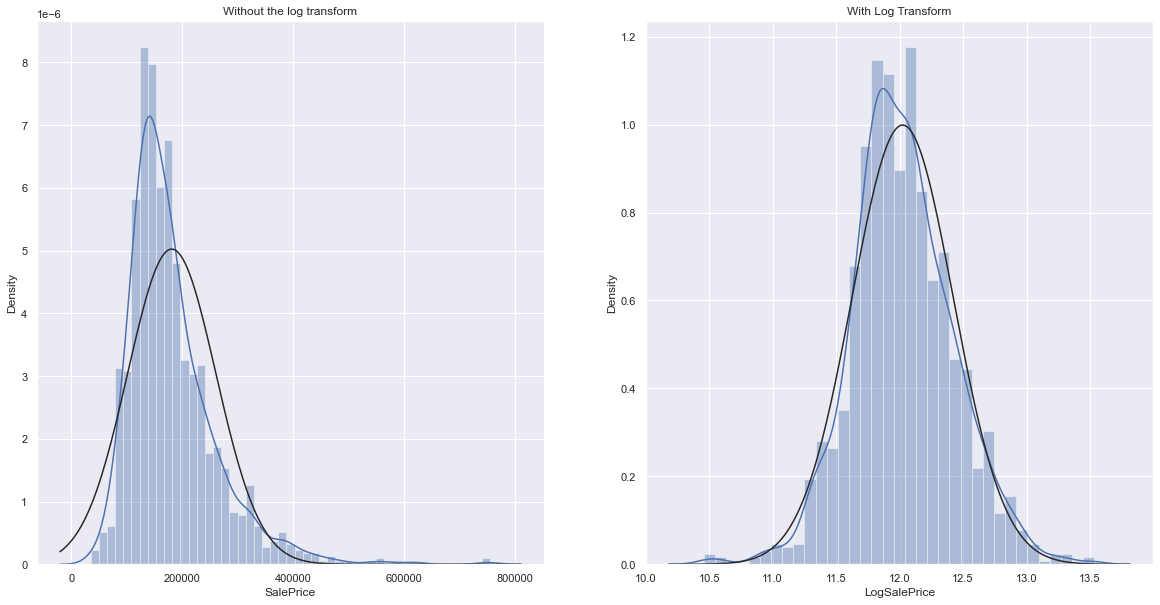

In [53]:
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.distplot(target, kde=True, fit=scipy.stats.norm)
plt.title('Without the log transform')

plt.subplot(1,2,2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)
plt.xlabel('LogSalePrice')
plt.title('With Log Transform')

plt.show()

Let's make the transformation: 

In [54]:
log_target=np.log(target)

# 10. Model Selection

### Split the Data

In [55]:
# we didn't shuffle the data, so the test set is still at the bottom
# the first 1460 rows belong to the train set; and the rest the test set

train0.index.max()

1459

In [56]:
train_final = data8.loc[:train0.index.max(), :].copy()
test_final = data8.loc[train0.index.max() + 1:, :].reset_index(drop=True).copy()

In [57]:
train_final

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functio

In [58]:
test_final

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functio

### Suggestions for Best Model

Here we are using pycaret which will test a whole range of models for us and give us a suggestion for which may be the most effective. 

In [59]:
from pycaret.regression import setup, compare_models

In [60]:
# _ = setup(data=pd.concat([train_final, log_target], axis=1), target='SalePrice')

In [61]:
#compare_models()

The models that pycaret flagged as the most promising are as follows: 
* CatBoost Regressor
* Bayesian Ridge
* Ridge Regression
* Light Gradient Boosting Machine
* Gradient Boosting Regressor
* Orthogonal Matching Pursuit

# 11. Fitting the Baseline Model

### Baseline Model

Let's fit a baseline model and see what kind of result we get. 

We will use the model that pycaret selected as the most promising, CatBoostRegressor.

In [62]:
baseline_model=CatBoostRegressor(verbose=0)

In [63]:
baseline_model.fit(train_final, log_target)

### Evaluation of Baseline Model

Rather than do a train/test split on the train_final dataset, we will instead evaluate our model by using cross-validation. With 10 splits, it will use one tenth of the data as a test set each time, until each tenth has had its' turn at being the test set. The results will represent the negative RMSE for the log transformed target. 

In [64]:
kf=KFold(n_splits=10)

results= cross_val_score(baseline_model, train_final, log_target, scoring='neg_mean_squared_error',cv=kf)

We need to do an exponential transformation on the results in order to bring the scores back to the original target metric. 

In [65]:
results #currently log-transformed

array([-0.0135257 , -0.00933667, -0.0104367 , -0.02303785, -0.02095082,
       -0.01089099, -0.01361612, -0.00905662, -0.01323413, -0.01658721])

In [67]:
np.exp(np.sqrt(np.mean(-results))) #brings the score back to the original target

1.1259257271864966

We can see that this model is performing well: the mean error is just 1.126 dollars! To put this in context, the mean house sales price is $180,921.

### Make First Submission

In [68]:
final_predictions= np.exp(baseline_model.predict(test_final))

In [69]:
submission= pd.concat([test_ids,pd.Series(final_predictions, name='SalePrice')], axis=1)

In [70]:
submission.head()

,Id,SalePrice
0,1461,125573.056
1,1462,157261.144
2,1463,184495.024
3,1464,190806.530
4,1465,182091.784


In [71]:
submission.to_csv('./new_submission.csv', index=False, header=True)

Kaggle score for this first submission: 0.12449

In [3]:
np.exp(0.12449)

1.1325706946966696

We can see that the RMSE for the test set was 1.1325, so our model is performing well. 

# 12. Hyperparameter Optimization

Next, let's see if we can improve the model using hyperparameter optimization. In this example, we are looking for the best parameters for the BaysianRidge model:

In [72]:
def br_objective(trial):
    n_iter = trial.suggest_int('n_iter', 50, 600)
    tol = trial.suggest_loguniform('tol', 1e-8, 10.0)
    alpha_1 = trial.suggest_loguniform('alpha_1', 1e-8, 10.0)
    alpha_2 = trial.suggest_loguniform('alpha_2', 1e-8, 10.0)
    lambda_1 = trial.suggest_loguniform('lambda_1', 1e-8, 10.0)
    lambda_2 = trial.suggest_loguniform('lambda_2', 1e-8, 10.0)
    
    model = BayesianRidge(
        n_iter=n_iter,
        tol=tol,
        alpha_1=alpha_1,
        alpha_2=alpha_2,
        lambda_1=lambda_1,
        lambda_2=lambda_2
    )
    
    model.fit(train_final, log_target)
    
    cv_scores = np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)))
    
    return np.mean(cv_scores)

In [73]:
#study = optuna.create_study(direction='minimize')
#study.optimize(br_objective, n_trials=100)

In [74]:
#study.best_params

The study gave us the following best parameters for BaysianRidge:

* 'n_iter': 187,
* 'tol': 1.9992245864727606e-05,
* 'alpha_1': 0.5687291000110867,
* 'alpha_2': 9.925481141053254,
* 'lambda_1': 0.0005677149275797934,
* 'lambda_2': 2.1100146157475213e-05

We followed the same process for the other models. 

# 13. Bagging Ensemble

Now we are going to feed the best parameteres into each of our best performing models and then see how each of the perform with k-fold validation:

In [75]:
catboost_params = {
    'iterations': 6000,
    'learning_rate': 0.005,
    'depth': 4,
    'l2_leaf_reg': 1,
    'eval_metric':'RMSE',
    'early_stopping_rounds': 200,
    'random_seed': 42
}

br_params = {
    'n_iter': 187,
    'tol': 1.9992245864727606e-05,
    'alpha_1': 0.5687291000110867,
    'alpha_2': 9.925481141053254,
    'lambda_1': 0.0005677149275797934,
    'lambda_2': 2.1100146157475213e-05
}

lightgbm_params = {
    'num_leaves': 39,
    'max_depth': 2,
    'learning_rate': 0.13705339989856127,
    'n_estimators': 273
}

ridge_params = {
    'alpha': 631.1412445239156
}

In [76]:
models = {
    "catboost": CatBoostRegressor(**catboost_params, verbose=0),
    "br": BayesianRidge(**br_params),
    "lightgbm": LGBMRegressor(**lightgbm_params),
    "ridge": Ridge(**ridge_params),
    "omp": OrthogonalMatchingPursuit()
}

In [77]:
for name, model in models.items():
    model.fit(train_final, log_target)
    print(name+ ' trained.')

catboost trained.
br trained.
lightgbm trained.
ridge trained.
omp trained.


### Evaluate

In [78]:
results= {}

kf= KFold(n_splits=10)

for name,model in models.items():
    result= np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)))
    results[name]= result

In [79]:
results

{'catboost': array([1.12021972, 1.09682891, 1.10665708, 1.15785186, 1.15402235,
        1.10855739, 1.12304013, 1.10114545, 1.12197375, 1.13346992]),
 'br': array([1.12300425, 1.10427934, 1.12406244, 1.16760338, 1.15412511,
        1.12798872, 1.12557382, 1.10230027, 1.18575222, 1.1327591 ]),
 'lightgbm': array([1.12927898, 1.10483239, 1.11283492, 1.16835401, 1.16695822,
        1.11358874, 1.12790915, 1.10885958, 1.14491762, 1.14087521]),
 'ridge': array([1.12286405, 1.10508985, 1.12400041, 1.16917643, 1.15682945,
        1.12098928, 1.12636149, 1.10344533, 1.17998562, 1.13329896]),
 'omp': array([1.13163194, 1.10136166, 1.12704954, 1.18074775, 1.16256399,
        1.17119603, 1.12960897, 1.12360152, 1.1832052 , 1.15073542])}

In [80]:
for name, result in results.items():
    print("----------\n" + name)
    print(np.mean(result))
    print(np.std(result))

----------
catboost
1.1223766557897308
0.01982368408684816
----------
br
1.1347448654371235
0.025344582355834946
----------
lightgbm
1.1318408821014765
0.02189302035431408
----------
ridge
1.134204086720898
0.024686693336830007
----------
omp
1.1461702025542813
0.026175319620290037


In [108]:
new=[]   

for name, result in results.items():
    new.append(np.mean(result))
    
print(np.mean(new))

1.133867338520702


The mean RMSE of our models is 1.34. Next, we will combine the models to make our final predictions, weighting each model based on how it performed above.

### Combine Predictions

In [81]:
final_predictions = (
    0.4 * np.exp(models['catboost'].predict(test_final)) +
    0.2 * np.exp(models['br'].predict(test_final)) +
    0.2 * np.exp(models['lightgbm'].predict(test_final)) +
    0.1 * np.exp(models['ridge'].predict(test_final)) +
    0.1 * np.exp(models['omp'].predict(test_final))
)

In [82]:
final_predictions

array([122745.05949658, 158018.30096487, 180634.89149895, ...,
       160706.05560867, 116426.65886143, 218807.67399117])

### Make Submission

In [84]:
submission = pd.concat([test_ids, pd.Series(final_predictions, name='SalePrice')], axis=1)
submission

,Id,SalePrice
0,1461,122745.059
1,1462,158018.301
2,1463,180634.891
3,1464,192844.452
4,1465,191498.909
...,...,...
1454,2915,86006.120
1455,2916,81428.278
1456,2917,160706.056
1457,2918,116426.659


In [85]:
submission.to_csv('./new2submission.csv', index=False, header=True)

New Kaggle score: 0.12125

In [113]:
np.exp(0.12125)

1.1289071038679037

Our RMSE on the test set is now 1.1289 which is an improvement on our baseline model!

# 14. Conclusion and Next Steps

We have an effective model that is making good predictions. However, there is scope to further improve the model:

* **Feature Selection**: there may be some features that we can try dropping in order to improve the model
* **Feature Engineering**: there are no doubt more features that we extrapolate from the data the the model would find useful
* **Outliers**: we did not remove the potential outliers we identified. We can do so and see if this improves our model